In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
create_time = pd.read_csv("../results_03_15/FAST_KNN_NO_ObjIndex_L9_search_sub_timeline_100000_100000.csv", names=['obj_search', 'insert', 'ar', 'des_count', 'level']).reset_index()
create_time['name'] = 'fast'
create_time['obj_search'] = create_time['obj_search'] / 1000000
create_time['insert'] = create_time['insert'] / 1000000
create_time = create_time.melt(id_vars=['index', 'name', 'ar', 'des_count', 'level'], var_name='stage', value_name='time')

create_time

,index,name,ar,des_count,level,stage,time
0,0,fast,3868222,2.095607e+01,NaN,obj_search,0.000000
1,1,fast,22025,1.797693e+308,NaN,obj_search,0.000001
2,2,fast,23458,3.016183e-01,NaN,obj_search,0.000002
3,3,fast,17108,3.928520e-01,NaN,obj_search,0.000003
4,4,fast,6722,1.797693e+308,NaN,obj_search,0.000004
...,...,...,...,...,...,...,...
199995,99995,fast,3765,1.181172e+01,NaN,insert,0.022338
199996,99996,fast,1453,1.346793e+00,NaN,insert,0.180248
199997,99997,fast,1606,1.017120e+00,NaN,insert,0.206481
199998,99998,fast,3664,3.827053e-01,NaN,insert,0.845826


## Creation time

(0.0, 10.0)

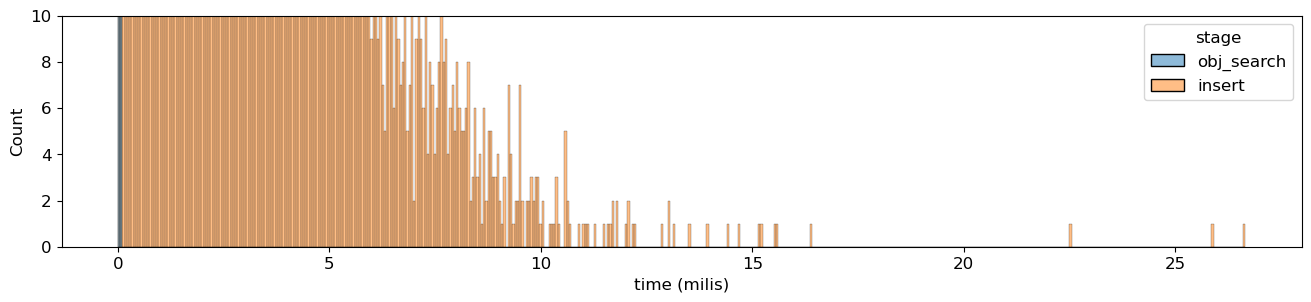

In [3]:
plt.figure(figsize=(16,3))
sns.histplot(x='time', bins=500, hue='stage', multiple='layer', data=create_time)
plt.xlabel('time (milis)')
plt.ylim(0, 10)

**Miserable queries**

Queries that takes too much time (>100 milis). 

In [4]:
miserable_queries = create_time[create_time['time'] > 5].sort_values('time', ascending=False)
miserable_queries

,index,name,ar,des_count,level,stage,time
107844,7844,fast,14013,1.797693e+308,NaN,insert,26.651615
103493,3493,fast,30052,1.398108e+02,NaN,insert,25.896353
135600,35600,fast,10242,1.797693e+308,NaN,insert,22.542585
142857,42857,fast,14505,1.797693e+308,NaN,insert,16.376047
101358,1358,fast,22477,1.797693e+308,NaN,insert,15.609281
...,...,...,...,...,...,...,...
159506,59506,fast,2985,1.165382e+02,NaN,insert,5.008343
146456,46456,fast,9207,4.817721e+01,NaN,insert,5.006239
126776,26776,fast,5018,1.797693e+308,NaN,insert,5.005764
101901,1901,fast,15497,1.317258e+02,NaN,insert,5.000795


(0.0, 25.0)

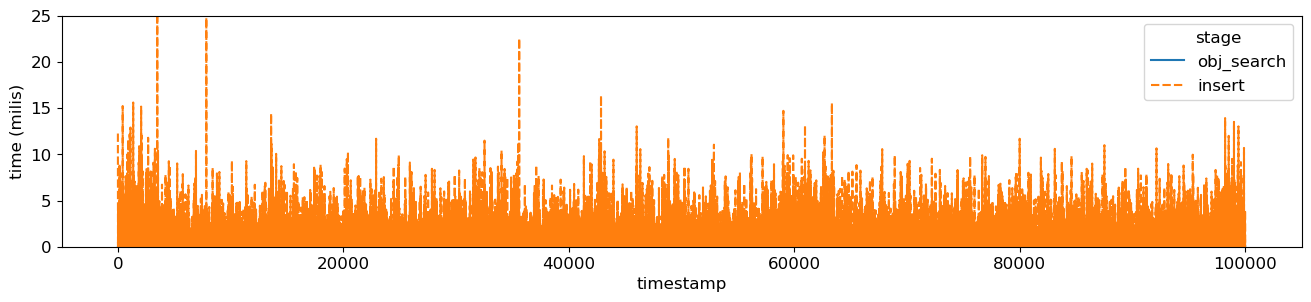

In [5]:
# step = 500000
# for i in range(0, 2500000, step):
plt.figure(figsize=(16,3))
sns.lineplot(x='index', y='time', hue='stage', style='stage', data=create_time)
plt.xlabel('timestamp')
plt.ylabel('time (milis)')
plt.ylim(0, 25)

Relative time (FAST vs CkQST)

In [6]:
# relative_create = create_time[create_time['stage'] == 'insert']['time'].reset_index() - create_time[create_time['stage'] == 'obj_search']['time'].reset_index()
# relative_create
# plt.figure(figsize=(16,8))
# sns.lineplot(data=relative_create)
# plt.xlabel('timestamp')
# plt.ylabel('time (milis)')

## Load Queries

In [7]:
queries_df = pd.read_json('../../data/exported/places_o200000_q2500000_scaled.json', lines=True);
queries_df = queries_df.iloc[200000:, :].reset_index(drop=True).drop(columns=['id']).reset_index()

queries_df.tail()

,index,x,y,keywords,scaled
2499995,2499995,409.894898,103.097463,"[telephone, cellular]",True
2499996,2499996,402.284307,107.998284,[contractor],True
2499997,2499997,406.953882,110.040834,[church],True
2499998,2499998,412.621720,107.253521,"[lounge, drinking, eating, cocktail]",True
2499999,2499999,412.835319,107.262331,"[coping, plastering, tiling, pool, swimming]",True


### Properties of miserable queries

In [8]:
queries_df.shape

(2500000, 5)

In [9]:
details = queries_df.join(miserable_queries.set_index('index'), on='index').dropna().sort_values('time', ascending=False)
# details = details[details['name'] == 'fast']
inf_val = details['ar'].max()
details['ar'] = details['ar'].apply(lambda x: np.inf if x >= inf_val else x)
all = details.drop(columns=['x', 'y']).rename(columns={'time': 'insertion time (milis)'})

In [10]:
obj_search = all[all['stage'] == 'obj_search']
insert = all[all['stage'] == 'insert']

# insert#.join(ckqsts, rsuffix='_')
insert.head(25)
# all.head(25)

,index,keywords,scaled,name,ar,des_count,level,stage,insertion time (milis)


In [11]:
obj_search.head(25)

,index,keywords,scaled,name,ar,des_count,level,stage,insertion time (milis)


## Query size vs Insertion time

In [12]:
stats = create_time.copy()
stats = queries_df.join(stats.set_index('index'), on='index').dropna()

In [13]:
stats['n_keywords'] = stats['keywords'].apply(lambda x: min(len(x), 5))

### Query index insert

<Axes: >

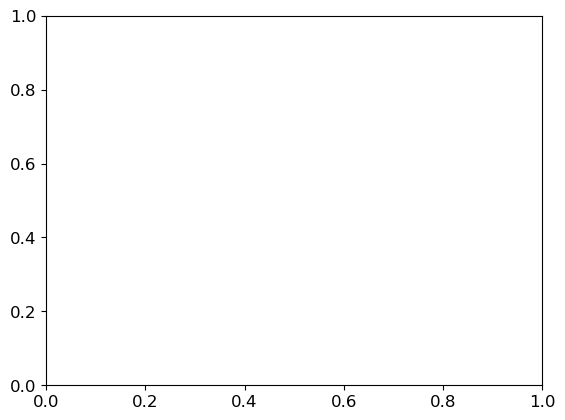

In [14]:
insert_only = pd.DataFrame(stats[stats['stage'] == 'insert'])
insert_only['ar'] = insert_only['ar'].apply(lambda x: 512 if x > 512 else x)

sns.scatterplot(y='time', x='ar', data=insert_only.loc[:, ['ar', 'time']])

<Axes: >

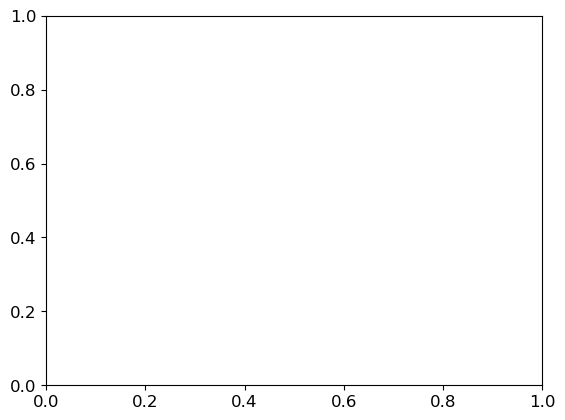

In [15]:
sns.scatterplot(y='time', x='n_keywords', data=insert_only.loc[:, ['n_keywords', 'time']])

<Axes: >

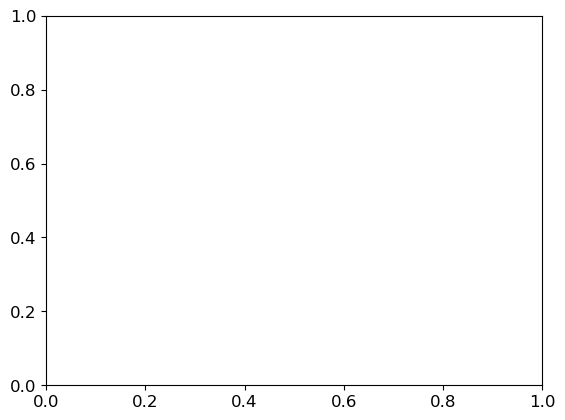

In [16]:
sns.scatterplot(y='time', x='des_count', data=insert_only.loc[:, ['des_count', 'time']])

<Axes: >

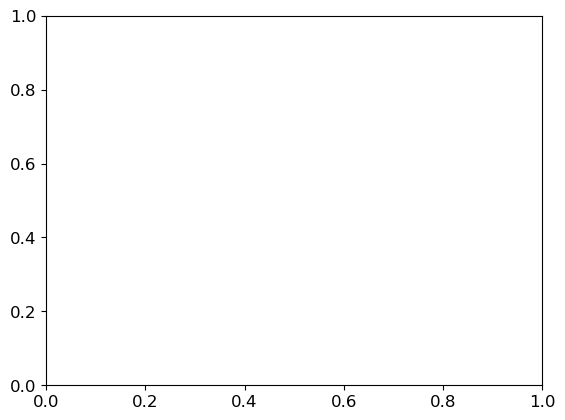

In [17]:
sns.scatterplot(y='time', x='level', data=insert_only.loc[:, ['level', 'time']])

In [18]:
out = insert_only.loc[:, ['level', 'time']]

<Axes: >

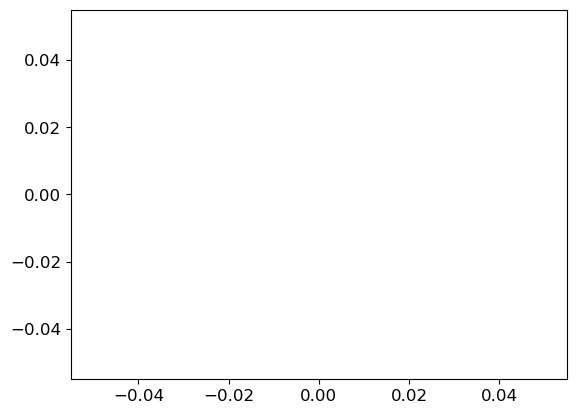

In [19]:
sns.histplot(out['level'])

(0.0, 15000.0)

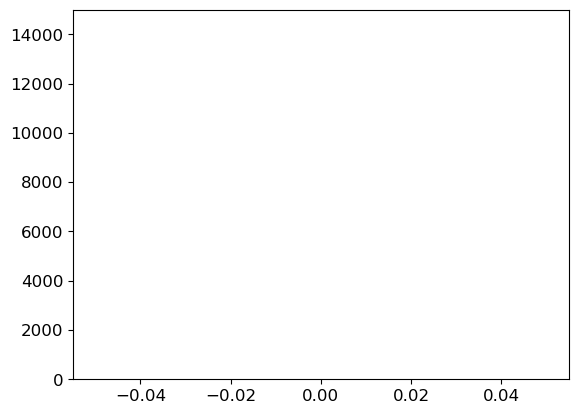

In [20]:
sns.histplot(out['level'])
plt.ylim(0, 15000)

In [21]:
hist_out = out.groupby('level').mean().reset_index()
sns.barplot(x='level', y='time', data=hist_out)
plt.ylabel('avg. insert time (query index - fast)')

ValueError: min() arg is an empty sequence

### Obj index search

In [ ]:
search_only = pd.DataFrame(stats[stats['stage'] == 'obj_search'])
search_only['ar'] = search_only['ar'].apply(lambda x: 512 if x > 512 else x)

sns.scatterplot(y='time', x='ar', data=search_only.loc[:, ['ar', 'time']])

In [ ]:
sns.scatterplot(y='time', x='n_keywords', data=search_only.loc[:, ['n_keywords', 'time']])

In [ ]:
sns.scatterplot(y='time', x='des_count', data=search_only.loc[:, ['des_count', 'time']])

In [ ]:
sns.scatterplot(y='time', x='level', data=search_only.loc[:, ['level', 'time']])